<a href="https://colab.research.google.com/github/aloofzebra03/Ielektron-Internship/blob/main/Project/Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [35]:
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Reshape

In [36]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, TerminateOnNaN, CSVLogger

In [37]:
import numpy as np
from PIL import Image
import xml.etree.ElementTree as ET
import os
import pickle

class_map = {'person': 0, 'rider': 1, 'motorcycle': 2, 'bicycle': 3, 'autorickshaw': 4, 'car': 5, 'truck': 6, 'bus': 7, 'train': 8, 'traffic light':9}

# Specify the paths to your dataset
train_dirs = ['/content/drive/MyDrive/IDD_lite/train/BLR-2018-03-22_17-39-26_2_frontFar', '/content/drive/MyDrive/IDD_lite/train/BLR-2018-03-22_17-39-26_3_frontFar'
              ,'/content/drive/MyDrive/IDD_lite/train/BLR-2018-04-16_15-24-27_frontFar','/content/drive/MyDrive/IDD_lite/train/BLR-2018-04-16_15-44-27_frontFar'
              ,'/content/drive/MyDrive/IDD_lite/train/BLR-2018-04-16_15-54-27_frontFar','/content/drive/MyDrive/IDD_lite/train/BLR-2018-04-16_16-04-27_frontFar'
              ,'/content/drive/MyDrive/IDD_lite/train/BLR-2018-04-16_16-14-27_frontFar']
val_dirs = ['/content/drive/MyDrive/IDD_lite/test/BLR-2018-04-19_17-06-55_frontFar', '/content/drive/MyDrive/IDD_lite/test/BLR-2018-04-19_17-16-55_frontFar'
              ,'/content/drive/MyDrive/IDD_lite/test/BLR-2018-04-19_17-26-55_frontFar']


In [38]:

# Helper function to parse XML files
def parse_annotation(xml_file, class_map):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    boxes = []
    labels = []
    for obj in root.findall('object'):
        class_name = obj.find('name').text
        if class_name in class_map:
            class_id = class_map[class_name]
            bbox = obj.find('bndbox')
            xmin = int(bbox.find('xmin').text)
            ymin = int(bbox.find('ymin').text)
            xmax = int(bbox.find('xmax').text)
            ymax = int(bbox.find('ymax').text)
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(class_id)
    return np.array(boxes), np.array(labels)

# Function to find all JPEG and XML files in the given directory
def find_files(directory, image_extension, annotation_extension):
    image_files = []
    annotation_files = []
    for root, _, filenames in os.walk(directory):
        for filename in filenames:
            if filename.endswith(image_extension):
                image_files.append(os.path.join(root, filename))
            elif filename.endswith(annotation_extension):
                annotation_files.append(os.path.join(root, filename))
    return image_files, annotation_files

# Function to match image files with their corresponding XML annotation files
def match_files(image_files, annotation_files):
    image_to_annotation = {}
    for image_file in image_files:
        base_name = os.path.splitext(os.path.basename(image_file))[0]
        for annotation_file in annotation_files:
            if os.path.splitext(os.path.basename(annotation_file))[0] == base_name:
                image_to_annotation[image_file] = annotation_file
                break
    return image_to_annotation

# Function to load dataset with padding
def load_dataset(dirs, class_map, max_boxes=100):
    images = []
    boxes_and_labels = []

    for directory in dirs:
        image_files, annotation_files = find_files(directory, '.jpg', '.xml')
        image_to_annotation = match_files(image_files, annotation_files)
        for image_file, annotation_file in image_to_annotation.items():
            image = np.array(Image.open(image_file).resize((300, 300)))
            box, label = parse_annotation(annotation_file, class_map)
            if len(box) == 0:  # Skip images with no bounding boxes
                continue
            images.append(image)
            padded_boxes = np.zeros((max_boxes, 4))
            padded_labels = np.full(max_boxes,-1,dtype=int)
            if len(box) > 0:
                padded_boxes[:len(box)] = box
                padded_labels[:len(label)] = label
            boxes_and_labels.append(np.concatenate([padded_boxes, padded_labels[:, None]], axis=-1))

    return np.array(images), np.array(boxes_and_labels)

def save_dataset(images, boxes_and_labels, file_path):
    with open(file_path, 'wb') as f:
        pickle.dump((images, boxes_and_labels), f)

def load_dataset_from_file(file_path):
    with open(file_path, 'rb') as f:
        return pickle.load(f)

# Paths to save/load the datasets
train_dataset_file = '/content/drive/MyDrive/IDD_lite/train_dataset.pkl'
val_dataset_file = '/content/drive/MyDrive/IDD_lite/val_dataset.pkl'

# Load or save the training dataset
if os.path.exists(train_dataset_file):
    train_images, train_boxes_and_labels = load_dataset_from_file(train_dataset_file)
else:
    train_images, train_boxes_and_labels = load_dataset(train_dirs, class_map)
    save_dataset(train_images, train_boxes_and_labels, train_dataset_file)
print('done')
# Load or save the validation dataset
if os.path.exists(val_dataset_file):
    val_images, val_boxes_and_labels = load_dataset_from_file(val_dataset_file)
else:
    val_images, val_boxes_and_labels = load_dataset(val_dirs, class_map)
    save_dataset(val_images, val_boxes_and_labels, val_dataset_file)
print('All Done')

done
All Done


In [39]:
train_images.shape

(1933, 300, 300, 3)

In [40]:
train_boxes_and_labels.shape

(1933, 100, 5)

In [41]:
np.isnan(train_boxes_and_labels).any()

False

In [42]:
# Load the pre-trained model
pretrained_model_path = '/content/drive/MyDrive/IDD_lite/VGG_coco_SSD_300x300_iter_400000_subsampled_34_classes.h5'
num_classes = 10  # Your custom number of classes
input_shape = (300, 300, 3)

In [43]:
# Create the SSD300 model
base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape, include_top=False)
x = base_model.output

In [44]:
# Add additional SSD layers
x = Conv2D(256, (3, 3), padding='same', activation='relu')(x)
x = Conv2D(num_classes + 4, (1, 1))(x)
x = Reshape((-1, num_classes + 4))(x)

In [45]:
predictions = x

model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)

# Load pre-trained weights
model.load_weights(pretrained_model_path, by_name=True, skip_mismatch=True)


In [46]:
import numpy as np

In [47]:
# Custom loss function for SSD
def smooth_l1_loss(y_true, y_pred):
    diff = tf.abs(y_true - y_pred)
    less_than_one = tf.cast(tf.less(diff, 1.0), tf.float32)
    loss = less_than_one * 0.5 * tf.square(diff) + (1.0 - less_than_one) * (diff - 0.5)
    return loss

def ssd_loss(y_true, y_pred):

    y_true_bboxes = y_true[:, :, :4]
    y_true_labels = y_true[:, :, 4]
    y_pred_bboxes = y_pred[:, :, :4]
    y_pred_labels = y_pred[:, :, 4:]
    # Calculate the localization loss (smooth L1 loss)
    localization_loss = smooth_l1_loss(y_true_bboxes, y_pred_bboxes)
    # tf.print("smooth_l1_loss:", localization_loss)
    localization_loss = tf.reduce_sum(localization_loss, axis=-1)  # Reduce sum over the bounding box coordinates
    # tf.print("Localization loss 2:", localization_loss)

    # Calculate the confidence loss (categorical crossentropy)
    confidence_loss = tf.keras.losses.sparse_categorical_crossentropy(y_true_labels, y_pred_labels)

    # tf.print("Confidence loss:", confidence_loss)

    total_loss = tf.reduce_mean(localization_loss + confidence_loss)
    # tf.print("Total loss:", total_loss)

    return total_loss


# Compile the model with the correct optimizer
model.compile(optimizer=Adam(learning_rate=0.0001), loss=ssd_loss)

# Define callbacks
checkpoint = ModelCheckpoint('ssd300_finetuned.h5', monitor='val_loss', save_best_only=True, save_weights_only=True)
learning_rate_scheduler = LearningRateScheduler(schedule=lambda epoch: 0.0001 * 0.1**(epoch // 10))
terminate_on_nan = TerminateOnNaN()
csv_logger = CSVLogger('ssd300_training_log.csv')

# Train the model
batch_size = 32
epochs = 20

history = model.fit(
    train_images, train_boxes_and_labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(val_images, val_boxes_and_labels),
    callbacks=[checkpoint, learning_rate_scheduler,terminate_on_nan, csv_logger]
)

smooth_l1_loss: [[[330.535767 361.510773 461.413452 465.880829]
  [475.543823 416.91037 493.489929 437.1474]
  [656.579 405.419647 674.675354 428.439148]
  ...
  [0.0577236861 0.572517753 0.029604448 0.0429406166]
  [0.158813179 0.375348747 0.0242000744 0.56836617]
  [0.0191339254 0.00235139322 0.0592132136 0.240495205]]

 [[671.685852 441.310883 695.97821 472.661072]
  [700.488586 454.676025 726.94281 477.958496]
  [865.288818 487.043304 904.013367 567.831543]
  ...
  [0.236860976 0.279454142 0.000143016659 1.02579916]
  [0.532158136 0.00759963738 0.00213051378 0.0396045111]
  [0.00338458922 0.138863221 0.158573925 0.00450807298]]

 [[900.435486 551.89209 1019.64923 721.383]
  [0.0250462815 0.0670236871 0.0130405584 0.465191245]
  [0.13382481 0.505321145 0.28283006 0.0433337614]
  ...
  [0.000169844978 0.0912471786 0.0492984243 0.100105368]
  [0.349739283 0.842771053 0.00440745708 0.419317663]
  [0.00419189455 0.714941263 0.00651572319 0.185109138]]

 ...

 [[589.673096 479.715271 606

In [ ]:
model.save('/content/drive/MyDrive/IDD_lite/model_trained.h5')

Exception ignored in: <function _xla_gc_callback at 0x7b92dd83caf0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 98, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


In [ ]:
model.output_shape

(None, 100, 14)

In [ ]:
# Making Predictions

# Making Predictions

In [14]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

In [15]:
from tensorflow.keras.preprocessing import image
import numpy as np

def preprocess_image(img_path, target_size=(300, 300)):
    img = image.load_img(img_path, target_size=target_size)
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    return img


In [16]:
def predict_image(model, preprocessed_image):
    predictions = model.predict(preprocessed_image)
    return predictions


In [17]:
def decode_predictions(predictions, class_map, confidence_threshold=0.5):
    bboxes = predictions[..., :4]
    scores = predictions[..., 4:]

    # Get class labels with highest score
    class_ids = np.argmax(scores, axis=-1)
    confidences = np.max(scores, axis=-1)

    decoded_boxes = []
    for bbox, class_id, confidence in zip(bboxes[0], class_ids[0], confidences[0]):
        if confidence > confidence_threshold:
            class_name = [k for k, v in class_map.items() if v == class_id][0]
            decoded_boxes.append((class_name, confidence, bbox))
    return decoded_boxes



In [18]:
new_image_path = '/content/drive/MyDrive/IDD_lite/train/BLR-2018-04-16_16-14-27_frontFar/000054_r.jpg'

1/1 [==============================] - 2s 2s/step


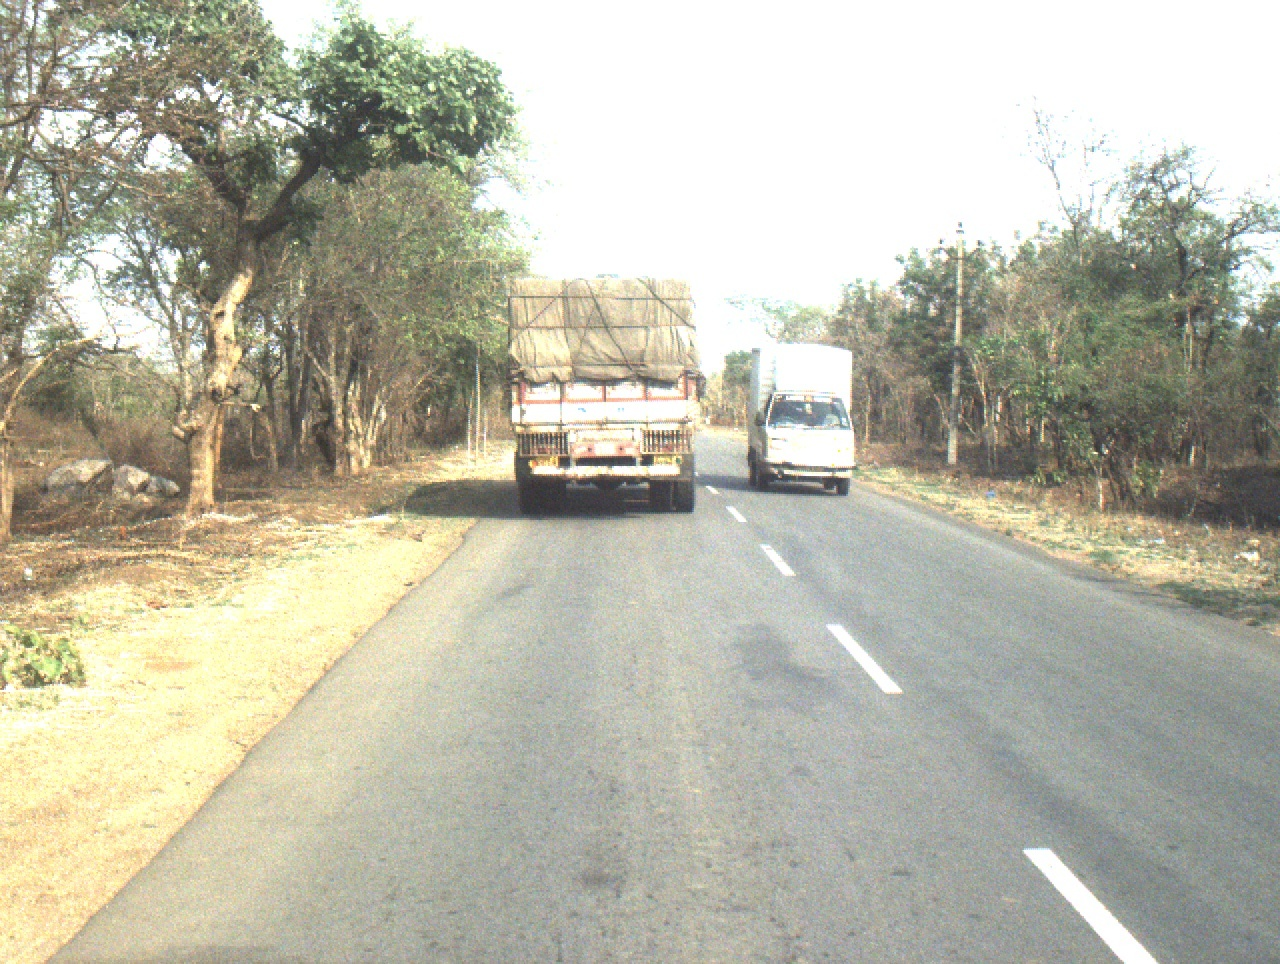

In [19]:
import cv2
import numpy as np
from PIL import Image
from google.colab.patches import cv2_imshow  # Specific to Google Colab

def draw_boxes_cv(image_path, predictions, class_map, confidence_threshold=0.5):
    # Load the image
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Image at {image_path} could not be loaded.")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    image_height, image_width, _ = image.shape

    # Iterate over each prediction
    for class_name, confidence, bbox in predictions:
        if confidence > confidence_threshold:
            # Convert bounding boxes from normalized to pixel values if necessary
            xmin, ymin, xmax, ymax = bbox
            if xmax <= 1.0 and ymax <= 1.0:  # Assuming normalized coordinates
                xmin = int(xmin * image_width)
                ymin = int(ymin * image_height)
                xmax = int(xmax * image_width)
                ymax = int(ymax * image_height)
            else:
                xmin, ymin, xmax, ymax = int(xmin), int(ymin), int(xmax), int(ymax)

            # Draw the rectangle
            cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (255, 0, 0), 2)  # Blue color with thickness of 2

            # Add label and confidence score
            label = f'{class_name}: {confidence:.2f}'
            label_size, _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 2)
            label_ymin = max(ymin, label_size[1] + 10)
            cv2.rectangle(image, (xmin, label_ymin - label_size[1] - 10), (xmin + label_size[0], label_ymin + 10), (255, 0, 0), cv2.FILLED)
            cv2.putText(image, label, (xmin, label_ymin - 7), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

    # Convert RGB to BGR for displaying with OpenCV
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    cv2_imshow(image)  # Use cv2_imshow for Google Colab
    cv2.waitKey(0)
    cv2.destroyAllWindows()

# Example usage
preprocessed_image = preprocess_image(new_image_path)
predictions = predict_image(model, preprocessed_image)
decoded_predictions = decode_predictions(predictions, class_map)
draw_boxes_cv(new_image_path, decoded_predictions, class_map)
